# Biomed Data Analyst Training Program - Chapter 3 
 Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Check the errata at (https://gedeck.github.io/mistat-code-solutions/ModernStatistics/) and the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues to see if the issue is known and a solution available.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

In [2]:
import random
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
import pingouin as pg
import matplotlib.pyplot as plt
import mistat

# Statistical Inference and Bootstrapping

To demonstrate the topics of this chapter, we use the dataset `Yield of tomatoes.CSV`. It contains the yield of tomatoes for 11 experiments under different treatment (A or B). 

First load the data:

In [3]:
data = pd.read_csv('Yield of tomatoes.CSV')
data.head()

,yield,treat
0,29.9,A
1,11.4,A
2,26.6,B
3,23.7,B
4,25.3,A


## Testing for Normality with Probability Plots

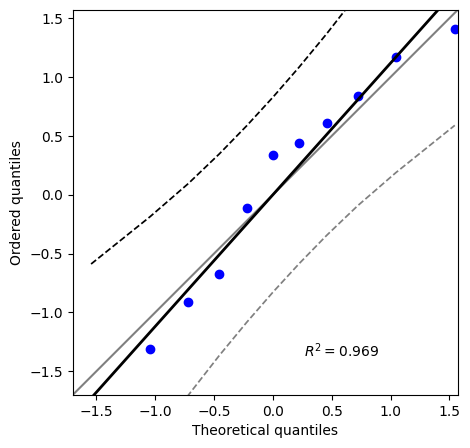

In [4]:
x = data['yield']
fig, ax = plt.subplots(figsize=[5, 5])
pg.qqplot(x, ax=ax)
ax.get_lines()[0].set_color('grey')
ax.get_lines()[0].set_markerfacecolor('none')
ax.get_lines()[1].set_color('black')
ax.get_lines()[2].set_color('black')
ax.get_lines()[3].set_color('grey')
plt.show()

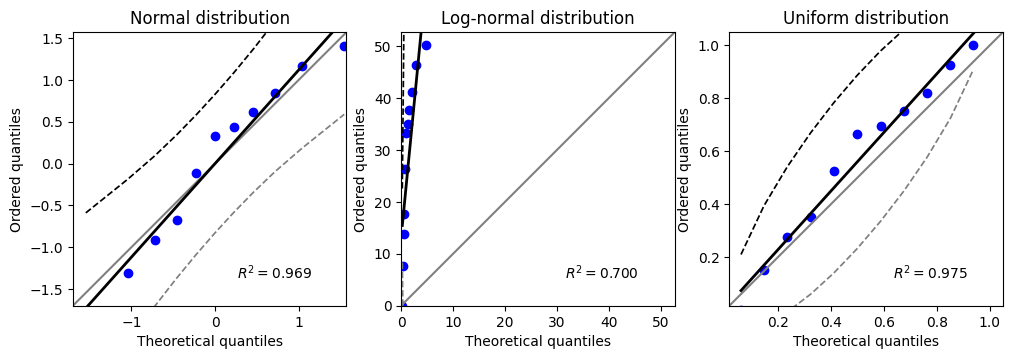

In [5]:
# Compare to different distribution functions
x = data['yield']

fig, axes = plt.subplots(figsize=[12, 4], ncols=3)
pg.qqplot(x, ax=axes[0])
axes[0].set_title('Normal distribution')

pg.qqplot(x, dist=stats.lognorm, sparams=[1], ax=axes[1])
axes[1].set_title('Log-normal distribution')

pg.qqplot(x, dist=stats.uniform, ax=axes[2])
axes[2].set_title('Uniform distribution')

for ax in axes:
  ax.get_lines()[0].set_color('grey')
  ax.get_lines()[0].set_markerfacecolor('none')
  ax.get_lines()[1].set_color('black')
  ax.get_lines()[2].set_color('black')
  ax.get_lines()[3].set_color('grey')
  # ax.get_lines()[4].set_color('grey')
plt.show()
res = stats.probplot(x)
r2_normal = res[1][2] ** 2
res = stats.probplot(x, dist=stats.lognorm, sparams=[1])
r2_lognormal = res[1][2] ** 2
res = stats.probplot(x, dist=stats.uniform)
r2_uniform = res[1][2] ** 2

## Bootstrap Sampling

### The Bootstrap Method

In [6]:
x = data['yield']

B = pg.compute_bootci(x, func=lambda x: np.mean(x), n_boot=1000,
                      confidence=0.95, return_dist=True, seed=1)

ci, distribution = B
print(f' Mean: {np.mean(distribution)}')
print(f' 95%-CI: {ci[0]:.1f} - {ci[1]:.1f}')

 Mean: 21.71498181818182
 95%-CI: 18.4 - 25.2


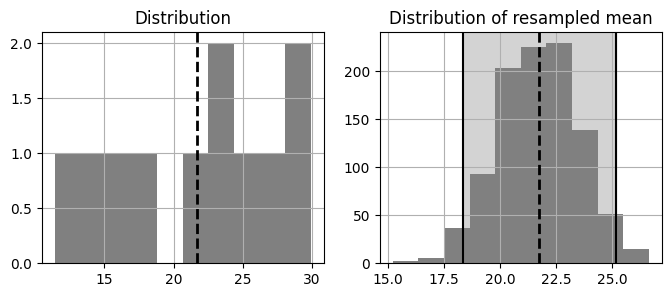

In [7]:
fig, axes = plt.subplots(figsize=[8, 3], ncols=2)
x.hist(ax=axes[0], color='grey')
axes[0].axvline(np.mean(distribution), color='black', linewidth=2, linestyle='--')

axes[1].axvspan(*ci, color='lightgrey')
pd.Series(distribution).hist(ax=axes[1], color='grey')
axes[0].set_title('Distribution')
axes[1].set_title('Distribution of resampled mean')
axes[1].axvline(ci[0], color='black')
axes[1].axvline(ci[1], color='black')
axes[1].axvline(np.mean(distribution), color='black', linewidth=2, linestyle='--')
plt.show()

### Studentized Test For the Mean
Assume that in previous studies the mean of yield was 18. Check if with the new treatments, the yield has increased significantly.

In [8]:
previous_yield = 18
x = data['yield']

ci = pg.compute_bootci(x, func='mean', n_boot=500,
                       confidence=0.95, method='per', seed=1)
print('bootstrap: ', ci)
print()

print(stats.ttest_1samp(x, previous_yield))
n = len(x) - 1
t_test_confinterval = stats.t.interval(0.95, n, loc=np.mean(x),
  scale=np.std(x)/np.sqrt(n))
print('t-test 95% conf-interval', t_test_confinterval)
print()

# get distribution of bootstrapped pvalues and determine percentage of
# values less than pvalue calculated from ttest_1samp
def stat_func(x):
    return stats.ttest_1samp(x, previous_yield).pvalue

ci, dist = pg.compute_bootci(x, func=stat_func, n_boot=500,
                       confidence=0.95, method='per',
                       seed=1, return_dist=True)
print(f'Bootstrap estimate of p-value {np.mean(dist)}')
print(f'Confidence interval for p-values {ci}')

bootstrap:  [18.34 25.21]

TtestResult(statistic=2.065152580477032, pvalue=0.06581645043595173, df=10)
t-test 95% conf-interval (17.702965745028052, 25.82430698224468)

Bootstrap estimate of p-value 0.14445793079949984
Confidence interval for p-values [0.   0.78]


### Studentized Test for The Difference of Two Means
Is there a significant difference between the two treatments?

In [9]:
X = data[data['treat'] == 'A']['yield'].reset_index(drop=True)
Y = data[data['treat'] == 'B']['yield'].reset_index(drop=True)

Xbar = np.mean(X)
Ybar = np.mean(Y)
SX = np.std(X, ddof=1)
SY = np.std(Y, ddof=1)
print(f'Xbar {Xbar:.2f} / SX {SX:.3f}')
print(f'Ybar {Ybar:.2f} / SY {SY:.3f}')
print()

def stat_func(x, y):
    return stats.ttest_ind(x, y, equal_var=False).statistic

tstar = []
for _ in range(500):
    Xstar = np.array(random.choices(X, k=len(X))) - Xbar
    Ystar = np.array(random.choices(Y, k=len(Y))) - Ybar
    tstar.append(stat_func(Xstar, Ystar))

# calculate confidence interval for t* and D*
alpha = 0.05
tstar_ci = np.quantile(tstar, [alpha/2, 1-alpha/2])
Dstar_ci = Xbar - Ybar + np.sqrt(SX**2/len(X) + SY**2/len(Y))*tstar_ci

print('tstar-CI', tstar_ci)
print('Dstar-CI', Dstar_ci)
print()

t0 = stat_func(X, Y)
print(f't0 {t0:.3f}')
pstar = (sum(tstar < -abs(t0)) + sum(abs(t0) < tstar)) / len(tstar)
print(f'P*-value {pstar:.2f}')

Xbar 20.84 / SX 7.246
Ybar 22.53 / SY 5.432

tstar-CI [-2.43300174  2.29189955]
Dstar-CI [-11.24650708   7.3058031 ]

t0 -0.431
P*-value 0.65


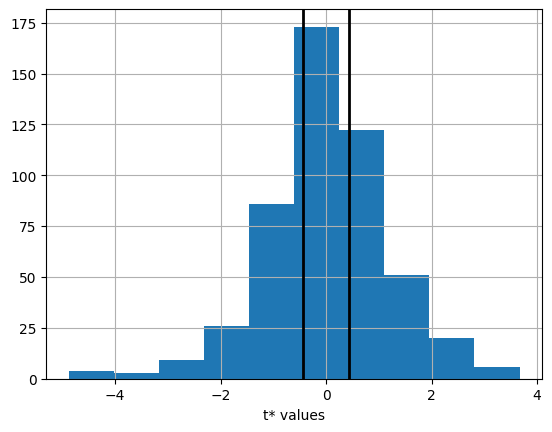

In [10]:
ax = pd.Series(tstar).hist()
ax.axvline(t0, color='black', lw=2)
ax.axvline(-t0, color='black', lw=2)
ax.set_xlabel('t* values')
plt.show()

### Comparing Statistics of Several Samples

#### Comparing Variances of Several Samples

In [11]:
yield_A = data[data['treat'] == 'A']['yield'].reset_index(drop=True)
yield_B = data[data['treat'] == 'B']['yield'].reset_index(drop=True)

# variance for each column
S2 = (yield_A.var(), yield_B.var())
F0 = max(S2) / min(S2)
print(f'S2 {np.round(S2,2)}')
print(f'F0 {F0:.2f}')

# Step 1: sample variances of bootstrapped samples for each column
B = {
    'A': pg.compute_bootci(yield_A, func='var', n_boot=500,
                       confidence=0.95, seed=1, return_dist=True),
    'B': pg.compute_bootci(yield_B, func='var', n_boot=500,
                       confidence=0.95, seed=2, return_dist=True),
}
Bt = pd.DataFrame({treat: B[treat][1] for treat in B})

# Step 2: compute Wi
Wi = Bt / S2

# Step 3: compute F*
FBoot = Wi.max(axis=1) / Wi.min(axis=1)
FBoot95 = np.quantile(FBoot, 0.95)
print('FBoot 95%', FBoot95)
print('ratio', sum(FBoot >= F0)/len(FBoot))

S2 [52.5  29.51]
F0 1.78
FBoot 95% 8.51028433638571
ratio 0.418


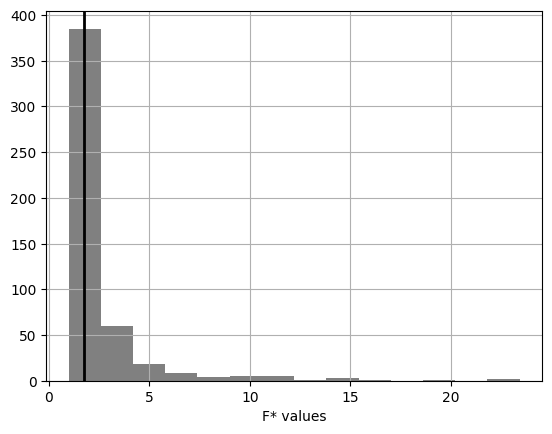

In [12]:
# some of the FBoot values are very high, remove these
FBoot = FBoot[FBoot < 50]


ax = pd.Series(FBoot).hist(bins=14, color='grey')
ax.axvline(F0, color='black', lw=2)
ax.set_xlabel('F* values')
plt.show()

#### Comparing Several Means:  The One-Way Analysis of Variance

F = 0.219


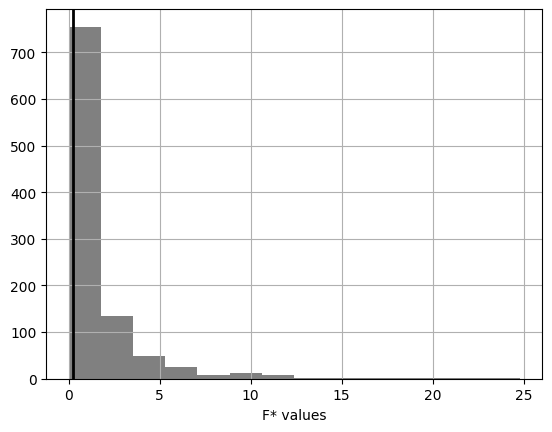

In [13]:
def test_statistic_F(samples):
    ''' Calculate test statistic F from samples '''
    k = len(samples)
    Ni = np.array([len(sample) for sample in samples])
    N = np.sum(Ni)
    XBni = np.array([np.mean(sample) for sample in samples])
    S2ni = np.array([np.var(sample, ddof=1) for sample in samples])
    XBB = np.sum(Ni * XBni) / N
    Sn = np.sum(Ni*(XBni - XBB)**2) / (k-1)
    Sd = np.sum((Ni-1)*S2ni) / (N-1)
    F0 = Sn / Sd
    return F0, XBni, XBB

samples = [yield_A, yield_B]
F0, XBni, XBB = test_statistic_F(samples)
DB = XBni - XBB
print(f'F = {F0:.3f}')

Ns = 1000
Fstar = []
for _ in range(Ns):
    Ysamples  = []
    for sample, DBi in zip(samples, DB):
        Xstar = np.array(random.choices(sample, k=len(sample)))
        Ystar = Xstar - DBi
        Ysamples.append(Ystar)
    Fs = test_statistic_F(Ysamples)[0]
    Fstar.append(Fs)

ax = pd.Series(Fstar).hist(bins=14, color='grey')
ax.axvline(F0, color='black', lw=2)
ax.set_xlabel('F* values')
plt.show()

In [14]:
def test_statistic_F(samples):
    return stats.f_oneway(*samples).statistic

F0 = test_statistic_F(samples)
print(f'F = {F0:.3f}')

# Calculate sample shifts
Ni = np.array([len(sample) for sample in samples])
N = np.sum(Ni)
XBni = np.array([np.mean(sample) for sample in samples])
XBB = np.sum(Ni * XBni) / N
DB = XBni - XBB

Ns = 1000
Fstar = []
for _ in range(Ns):
    Ysamples  = []
    for sample, DBi in zip(samples, DB):
        Xstar = np.array(random.choices(sample, k=len(sample)))
        Ysamples.append(Xstar - DBi)
    Fs = test_statistic_F(Ysamples)
    Fstar.append(Fs)

F = 0.197


## Bootstrap Tolerance Intervals

### Tolerance Interval for Continuous Variables

In [15]:
X = data['yield']

def getQuantile(x, p):
    return np.quantile(x, p)

B_025 = pg.compute_bootci(X, func=lambda x: getQuantile(x, p=0.025),
          n_boot=500, seed=1, return_dist=True)
B_975 = pg.compute_bootci(X, func=lambda x: getQuantile(x, p=0.975),
          n_boot=500, seed=1, return_dist=True)
print('0.025%', np.quantile(B_025[1], 0.025))
print('0.975%', np.quantile(B_975[1], 0.975))

0.025% 11.4
0.975% 29.9


## Non-Parametric Tests

### The Randomization Test

In [16]:
from itertools import permutations

sum_groups = data.groupby(by='treat').sum()
print(sum_groups)
T1, T2 = sum_groups['yield']
print(T1, T2)

assignments = []
for perm in sorted(set(permutations(data['treat']))):
    perm = list(perm)
    sum_groups = data.groupby(perm).sum()
    T1, T2 = sum_groups['yield']
    perm.append((T2 - T1) / 3)
    assignments.append(perm)

columns = list(data['yield'])
columns.append('D')

result = pd.DataFrame(assignments, columns=columns)

       yield
treat       
A      104.2
B      135.2
104.2 135.2


In [17]:
result

,29.9,11.4,26.6,23.7,25.3,28.5,14.2,17.9,16.5,21.1,24.3,D
0,A,A,A,A,A,B,B,B,B,B,B,1.866667
1,A,A,A,A,B,A,B,B,B,B,B,-0.266667
2,A,A,A,A,B,B,A,B,B,B,B,9.266667
3,A,A,A,A,B,B,B,A,B,B,B,6.800000
4,A,A,A,A,B,B,B,B,A,B,B,7.733333
...,...,...,...,...,...,...,...,...,...,...,...,...
457,B,B,B,B,B,A,A,A,A,B,A,12.200000
458,B,B,B,B,B,A,A,A,B,A,A,9.133333
459,B,B,B,B,B,A,A,B,A,A,A,10.066667
460,B,B,B,B,B,A,B,A,A,A,A,7.600000


In [18]:
_ = mistat.randomizationTest(yield_A, yield_B, np.mean,
                             aggregate_stats=lambda x: x[0] - x[1],
                             n_boot=500, seed=1)

Original stat is -1.693333
Original stat is at quantile 171 of 501 (34.13%)
Distribution of bootstrap samples:
 min: -10.16, median: -0.21,  max: 9.23


### The Wilcoxon Signed Rank Test

In [19]:
X = yield_A
Y = yield_B

print('Wilcoxon signed-rank test (unsuitable for ties)')
print(stats.ranksums(X, Y))
print('Mann-Whitney U test (suitable for ties)')
print(stats.mannwhitneyu(X, Y))

Wilcoxon signed-rank test (unsuitable for ties)
RanksumsResult(statistic=-0.3651483716701107, pvalue=0.7150006546880893)
Mann-Whitney U test (suitable for ties)
MannwhitneyuResult(statistic=13.0, pvalue=0.7922077922077921)


# Dataset "Assay stability test.csv"
Load the dataset

In [20]:
data = pd.read_csv('Assay stability test.csv')['Data']
print(data)

0      0.1029
1      0.0960
2      0.1040
3      0.1058
4      0.1038
        ...  
235    0.1031
236    0.1027
237    0.1025
238    0.1029
239    0.1027
Name: Data, Length: 240, dtype: float64


## Studentized Test For the Mean

In [21]:
ci = pg.compute_bootci(data, func='mean', n_boot=500, decimals=5,
                       confidence=0.95, method='per', seed=1)
print('bootstrap: ', ci)
print()

print(stats.ttest_1samp(data, 0.1035))
n = len(data) - 1
t_test_confinterval = stats.t.interval(0.95, n, loc=np.mean(data),
  scale=np.std(data)/np.sqrt(n))
print('t-test 95% conf-interval', t_test_confinterval)
print()

# get distribution of bootstrapped pvalues and determine percentage of
# values less than pvalue calculated from ttest_1samp
def stat_func(x):
    return stats.ttest_1samp(x, 0.1035).pvalue

ci, dist = pg.compute_bootci(data, func=stat_func, n_boot=500,
                       confidence=0.95, method='per',
                       seed=1, return_dist=True)
sum(dist < stats.ttest_1samp(data, 0.1035).pvalue) / len(dist)

bootstrap:  [0.10333 0.10379]

TtestResult(statistic=0.6090403872704343, pvalue=0.5430761425058344, df=239)
t-test 95% conf-interval (0.10332868855069345, 0.1038246447826399)



0.62

## Comparing Variances of Several Samples


In [22]:
data = pd.read_csv('Assay stability test.csv')
data_by_month = pd.DataFrame({
    month: subset['Data'].values for month, subset in data.groupby('Month')
})

In [23]:
data_by_month.head()

,3,6,9,12
0,0.1029,0.1037,0.1026,0.1035
1,0.0960,0.0952,0.1020,0.1002
2,0.1040,0.1039,0.1058,0.1025
3,0.1058,0.1057,0.1060,0.1019
4,0.1038,0.1008,0.1037,0.1025


<Axes: xlabel='Month', ylabel='Data'>

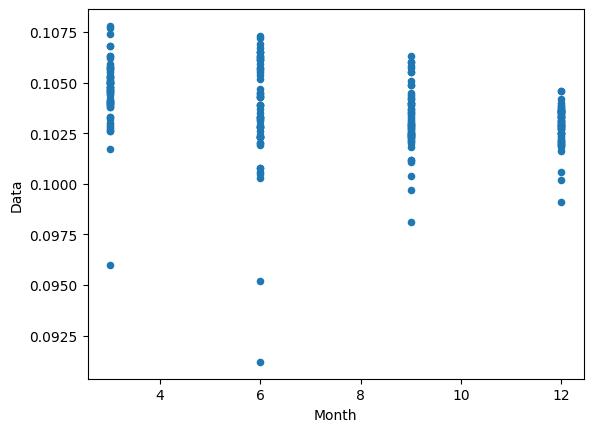

In [24]:
data.plot.scatter(x='Month', y='Data')

Data    Axes(0.125,0.11;0.775x0.77)
dtype: object

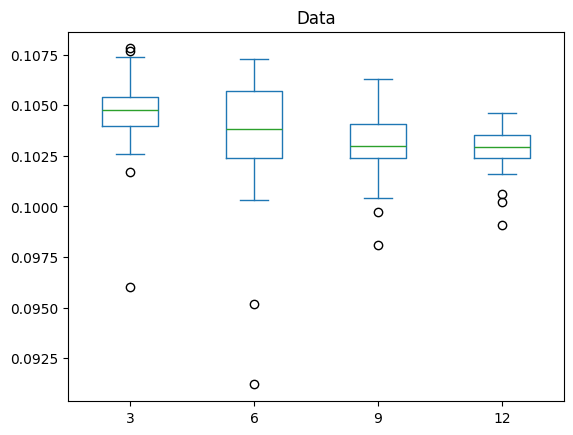

In [25]:
data.plot.box(by='Month')

In [26]:
# variance for each column
S2 = data_by_month.var(axis=0)
F0 = max(S2) / min(S2)
print('S2', S2)
print('F0', F0)

# Step 1: sample variances of bootstrapped samples for each column
B = {}
for seed, column in enumerate(data_by_month.columns):
    B[column] = pg.compute_bootci(data_by_month[column], func='var', n_boot=500,
                       confidence=0.95, seed=seed, return_dist=True)
Bt = pd.DataFrame({column: B[column][1] for column in data_by_month.columns})

# Step 2: compute Wi
Wi = Bt / S2

# Step 3: compute F*
FBoot = Wi.max(axis=1) / Wi.min(axis=1)
FBoot95 = np.quantile(FBoot, 0.95)
print('FBoot 95%', FBoot95)
print('ratio', sum(FBoot >= F0)/len(FBoot))

S2 3     2.889997e-06
6     7.421525e-06
9     2.402178e-06
12    9.523616e-07
dtype: float64
F0 7.792760191732697
FBoot 95% 3.466024551643586
ratio 0.0


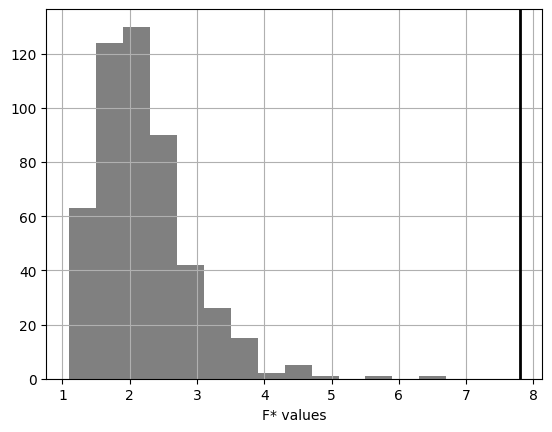

In [27]:
ax = pd.Series(FBoot).hist(bins=14, color='grey')
ax.axvline(F0, color='black', lw=2)
ax.set_xlabel('F* values')
plt.show()

#### Comparing Several Means:  The One-Way Analysis of Variance

F = 10.141


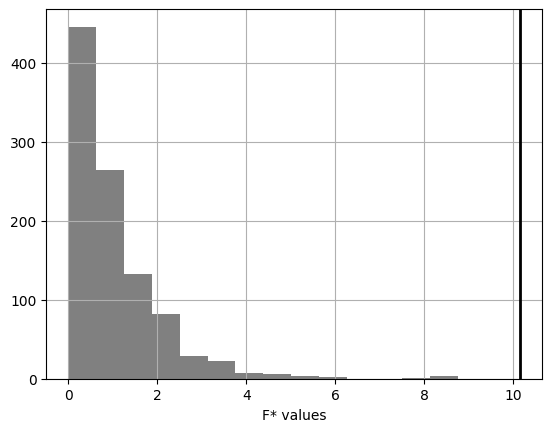

In [28]:
data = pd.read_csv('Assay stability test.csv')
data_by_month = pd.DataFrame({
    month: subset['Data'].values for month, subset in data.groupby('Month')
})


def test_statistic_F(samples):
    ''' Calculate test statistic F from samples '''
    k = len(samples)
    Ni = np.array([len(sample) for sample in samples])
    N = np.sum(Ni)
    XBni = np.array([np.mean(sample) for sample in samples])
    S2ni = np.array([np.var(sample, ddof=1) for sample in samples])
    XBB = np.sum(Ni * XBni) / N
    Sn = np.sum(Ni*(XBni - XBB)**2) / (k-1)
    Sd = np.sum((Ni-1)*S2ni) / (N-1)
    F0 = Sn / Sd
    return F0, XBni, XBB

samples = [data_by_month[3], data_by_month[6], data_by_month[9], data_by_month[12]]
F0, XBni, XBB = test_statistic_F(samples)
DB = XBni - XBB
print(f'F = {F0:.3f}')

Ns = 1000
Fstar = []
for _ in range(Ns):
    Ysamples  = []
    for sample, DBi in zip(samples, DB):
        Xstar = np.array(random.choices(sample, k=len(sample)))
        Ystar = Xstar - DBi
        Ysamples.append(Ystar)
    Fs = test_statistic_F(Ysamples)[0]
    Fstar.append(Fs)

ax = pd.Series(Fstar).hist(bins=14, color='grey')
ax.axvline(F0, color='black', lw=2)
ax.set_xlabel('F* values')
plt.show()

In [29]:
def test_statistic_F(samples):
    return stats.f_oneway(*samples).statistic

F0 = test_statistic_F(samples)
print(f'F = {F0:.3f}')

# Calculate sample shifts
Ni = np.array([len(sample) for sample in samples])
N = np.sum(Ni)
XBni = np.array([np.mean(sample) for sample in samples])
XBB = np.sum(Ni * XBni) / N
DB = XBni - XBB

Ns = 1000
Fstar = []
for _ in range(Ns):
    Ysamples  = []
    for sample, DBi in zip(samples, DB):
        Xstar = np.array(random.choices(sample, k=len(sample)))
        Ysamples.append(Xstar - DBi)
    Fs = test_statistic_F(Ysamples)
    Fstar.append(Fs)

F = 10.013


## Bootstrap Sampling

### The Bootstrap Method

In [30]:
assayStability = pd.read_csv('Assay stability test.csv')

B = pg.compute_bootci(assayStability['Data'], func=lambda x: np.mean(x), n_boot=1000,
                      confidence=0.95, return_dist=True, seed=1, decimals=4)

ci, distribution = B
print(f' Mean: {np.mean(distribution)}')
print(f' 95%-CI: {ci[0]} - {ci[1]}')

 Mean: 0.10357323708333334
 95%-CI: 0.1033 - 0.1038


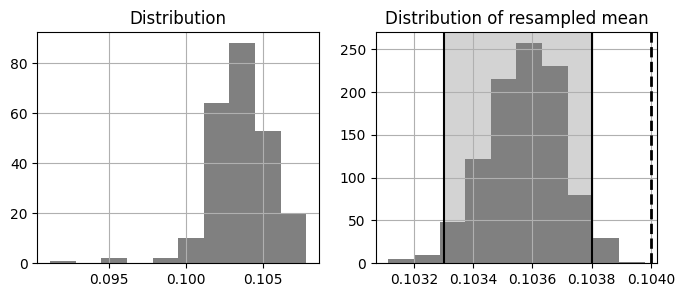

In [31]:
fig, axes = plt.subplots(figsize=[8, 3], ncols=2)
assayStability['Data'].hist(ax=axes[0], color='grey')
axes[1].axvspan(*ci, color='lightgrey')
pd.Series(distribution).hist(ax=axes[1], color='grey')
axes[0].set_title('Distribution')
axes[1].set_title('Distribution of resampled mean')
axes[1].axvline(ci[0], color='black')
axes[1].axvline(ci[1], color='black')
axes[1].axvline(0.104, color='black', linewidth=2, linestyle='--')
plt.show()